In [1]:
!pip install rouge-score

doneing metadata (setup.py) ... 
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.7 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 KB 14.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 KB 36.0 MB/s eta 0:00:00
doneng wheel for rouge-score (setup.py) ... 
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24951 sha256=d3d17f563dcad511391747d1b31c470b78e72b42625c938cb90d7ffca453e63f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
!pip install datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 KB 9.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 KB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 96.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 47.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 KB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 KB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 KB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.9/333.9 KB 114.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.6/206.6 KB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 KB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.8/219.8 KB 98.4 MB/s eta 0:00:00
 

In [3]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset
from transformers import BartTokenizer, get_linear_schedule_with_warmup
from rouge_score import rouge_scorer
from tqdm import tqdm

In [4]:
max_src_len   = 512      
max_tgt_len   = 128      
batch_size    = 8
epochs        = 25
lr            = 0.0001
weight_decay  = 0.01
grad_clip     = 1.0
beam_size     = 4
warmup_ratio  = 0.1

In [5]:
def tokenize(batch):
    src = tokenizer(batch['text'], max_length=max_src_len, truncation=True, padding='max_length')
    tgt = tokenizer(batch['target'], max_length=max_tgt_len, truncation=True, padding='max_length')
    
    return {'input_ids': src.input_ids, 'attention_mask': src.attention_mask, 'labels': tgt.input_ids}

In [6]:
def get_loaders(dataset_path):
    splits = load_dataset(dataset_path, split={"train":"train","validation":"validation"})
    tokenized = splits.map(tokenize, batched=True)
    tokenized.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
    valid_loader = DataLoader(tokenized['validation'], batch_size=batch_size, num_workers=4, pin_memory=True)
    train_loader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,persistent_workers=True)
    return train_loader, valid_loader

In [7]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
vocab_size = tokenizer.vocab_size

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

In [8]:
train_loader, valid_loader = get_loaders("nlplabtdtu/xlsum_en")

xlsum_en_train.jsonl:   0%|          | 0.00/600M [00:00<?, ?B/s]

xlsum_en_validation.jsonl:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

xlsum_en_test.jsonl:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/306521 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11535 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11535 [00:00<?, ? examples/s]

Map:   0%|          | 0/306521 [00:00<?, ? examples/s]

Map:   0%|          | 0/11535 [00:00<?, ? examples/s]

In [21]:
class TrainablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        self.pos = nn.Parameter(torch.zeros(max_len, d_model))
    def forward(self, x):
        seq_len = x.size(0)
        return x + self.pos[:seq_len].unsqueeze(1)

In [22]:
class TransformerSummarizer(nn.Module):
    
    def __init__(self, vocab_size, d_model=512, nhead=8, enc_layers=3, dec_layers=3, dim_ff=2048, dropout=0.1):
        super().__init__()
        self.embed       = nn.Embedding(vocab_size, d_model)
        self.pos_enc     = TrainablePositionalEncoding(d_model)
        self.pos_dec     = TrainablePositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model, nhead, enc_layers, dec_layers, dim_ff, dropout, activation='gelu', batch_first=True)
        self.out_proj    = nn.Linear(d_model, vocab_size)
        
    def forward(self, src, tgt, src_attention_mask=None, tgt_attention_mask=None):

        pad_id = tokenizer.pad_token_id
        src_kpm = (src == pad_id)
        tgt_kpm = (tgt == pad_id)
        
        src_emb = self.pos_enc(self.embed(src) * math.sqrt(self.embed.embedding_dim))
        tgt_emb = self.pos_dec(self.embed(tgt) * math.sqrt(self.embed.embedding_dim))
        
        size = tgt.size(1)
        tgt_mask = torch.triu(torch.full((size, size), True,dtype=torch.bool), 1).to(device)
        
        out = self.transformer(src_emb, tgt_emb, tgt_mask=tgt_mask,
                               src_key_padding_mask=src_kpm,
                               tgt_key_padding_mask=tgt_kpm,
                               memory_key_padding_mask=src_kpm
                              )
        
        return self.out_proj(out)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
model = TransformerSummarizer(vocab_size).to(device)

In [25]:
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

In [26]:
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, reduction='none')

In [52]:
total_steps = len(train_loader) * epochs
warmup_steps = int(total_steps * warmup_ratio)
    
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps
                                            )

In [53]:
def beam_search_decode(model, src_ids, src_mask=None, max_len=100, beam_size=5, 
                       device='cpu', tokenizer=None, length_penalty=1.0, 
                       early_stopping=True):
    
    model.eval()
    batch_size = src_ids.size(0)

    bos_token_id = getattr(tokenizer, 'bos_token_id', tokenizer.cls_token_id)
    eos_token_id = getattr(tokenizer, 'eos_token_id', tokenizer.sep_token_id)
    
    if batch_size > 1:
        return [
            beam_search_decode(
                model, src_ids[i:i+1],
                None if src_mask is None else src_mask[i:i+1],
                max_len, beam_size, device, tokenizer, length_penalty, early_stopping
            )
            for i in range(batch_size)
        ]

    # Initialize beam search variables
    current_tokens = torch.full((beam_size, 1), bos_token_id, dtype=torch.long, device=device)
    beam_scores = torch.zeros(beam_size, device=device)
    done_beams = [False] * beam_size

    expanded_src_ids = src_ids.expand(beam_size, -1)
    expanded_src_mask = None if src_mask is None else src_mask.expand(beam_size, -1)

    for step in range(max_len - 1):
        tgt_mask = None
        if hasattr(model, 'generate_square_subsequent_mask'):
            tgt_mask = model.generate_square_subsequent_mask(
                current_tokens.size(1)
            ).to(device)

        with torch.inference_mode():
            outputs = model(
                src=expanded_src_ids,
                tgt=current_tokens,
                src_attention_mask=expanded_src_mask,
                tgt_attention_mask=tgt_mask
            )

        next_token_logits = outputs[:, -1, :]
        next_token_logprobs = F.log_softmax(next_token_logits, dim=-1)

        vocab_size = next_token_logprobs.size(-1)
        expanded_scores = beam_scores.unsqueeze(1) + next_token_logprobs
        flat_scores = expanded_scores.view(-1)

        topk_scores, topk_indices = torch.topk(
            flat_scores, k=min(2 * beam_size, flat_scores.size(0))
        )

        beam_ix = topk_indices // vocab_size
        token_ix = topk_indices % vocab_size

        candidates = []
        for b, tok, sc in zip(beam_ix.tolist(), token_ix.tolist(), topk_scores.tolist()):
            if done_beams[b]:
                continue
            new_tokens = torch.cat([
                current_tokens[b],
                torch.tensor([tok], dtype=torch.long, device=device)
            ], dim=0)
            candidates.append({
                'tokens': new_tokens,
                'score': sc,
                'is_done': (tok == eos_token_id)
            })
            if len(candidates) >= beam_size:
                break

        if not candidates:
            new_tokens = torch.cat([
                current_tokens[0],
                torch.tensor([eos_token_id], dtype=torch.long, device=device)
            ], dim=0)
            candidates.append({
                'tokens': new_tokens,
                'score': beam_scores[0].item(),
                'is_done': True
            })

        while len(candidates) < beam_size:
            candidates.append(candidates[0])  # safe now due to fallback

        current_tokens = torch.stack([c['tokens'] for c in candidates])
        beam_scores = torch.tensor([c['score'] for c in candidates], device=device)
        done_beams = [c['is_done'] for c in candidates]

        if all(done_beams) and early_stopping:
            break

    seq_lens = current_tokens.size(1)
    adjusted_scores = beam_scores / (seq_lens ** length_penalty)
    best_idx = adjusted_scores.argmax().item()
    best_tokens = current_tokens[best_idx].tolist()

    return tokenizer.decode(best_tokens, skip_special_tokens=True)


In [54]:
def greedy_decode(model, src, src_mask=None, max_len=100, device=None, tokenizer=None):
    
    model.eval()
    if device is None:
        device = src.device

    bos_token_id = getattr(tokenizer, 'bos_token_id', tokenizer.cls_token_id)
    eos_token_id = getattr(tokenizer, 'eos_token_id', tokenizer.sep_token_id)

    decoder_input = torch.tensor([[bos_token_id]], device=device)
    
    with torch.inference_mode():
        for _ in range(max_len - 1):
            logits = model(
                src=src,
                tgt=decoder_input,
                src_attention_mask=src_mask,
                tgt_attention_mask=None
            )
            next_logits = logits[:, -1, :]
            next_token  = next_logits.argmax(dim=-1, keepdim=True)
            decoder_input = torch.cat([decoder_input, next_token], dim=1)
            if next_token.item() == eos_token_id:
                break
    
    return decoder_input

In [55]:
def generate_summary(model, src_ids, src_mask=None, max_len=100, 
                     method="beam_search", beam_size=5, device=None):
                     
    if method == "greedy":
        gen_ids = greedy_decode(
            model, src_ids, src_mask, max_len, device, tokenizer
        )
        return tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    elif method == "beam_search":
        return beam_search_decode(
            model, src_ids, src_mask, max_len, beam_size, device, tokenizer
        )

    else:
        raise ValueError(f"Unknown decoding method: {method}")

In [56]:
def load_checkpoint(checkpoint_path, model, optimizer=None, scheduler=None):
    
    try:
        print(f"Loading checkpoint from {checkpoint_path}")
        
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Model weights loaded successfully")
        
        if optimizer is not None and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print("Optimizer state restored")
        
        if scheduler is not None and 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            print("Scheduler state restored")
        
        metrics = {
            'train_loss': checkpoint.get('train_loss'),
            'val_loss': checkpoint.get('val_loss'),
            'rouge_scores': checkpoint.get('rouge_scores')
        }
        
        epoch = checkpoint.get('epoch', -1) + 1  # +1 because we want to start from the next epoch
        
        print(f"Checkpoint loaded from epoch {epoch}")
        if 'val_loss' in checkpoint:
            print(f"Validation loss: {checkpoint['val_loss']:.4f}")
        
        return model, optimizer, scheduler, epoch, metrics
        
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        raise e

In [61]:
def evaluate_model(model, val_loader, criterion, device, vocab_size, pad_token_id, tokenizer):
    model.eval()
    
    total_loss = 0
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    full_rouge_scores = []  # <-- Store full score objects

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    progress_bar = tqdm(val_loader, desc="Validating")
    
    with torch.inference_mode():
        for batch in progress_bar:
            src = batch['input_ids'].to(device, non_blocking=True)
            src_attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            tgt = batch['labels'].to(device, non_blocking=True)
            tgt_inp, tgt_lbl = tgt[:, :-1], tgt[:, 1:]
            
            tgt_attention_mask = (tgt_inp != pad_token_id).to(device, non_blocking=True)
            loss_mask = (tgt_lbl != pad_token_id).float()
            
            logits = model(
                src=src,
                tgt=tgt_inp,
                src_attention_mask=src_attention_mask,
                tgt_attention_mask=tgt_attention_mask
            )
            
            loss = criterion(logits.reshape(-1, vocab_size), tgt_lbl.reshape(-1))
            masked_loss = (loss * loss_mask.reshape(-1)).sum() / max(loss_mask.sum(), 1)
            total_loss += masked_loss.item()
            
            batch_size = src.size(0)
            for i in range(batch_size):
                summary = generate_summary(
                    model=model,
                    src_ids=src[i:i+1],
                    src_mask=src_attention_mask[i:i+1],
                    max_len=100,
                    method="beam_search",
                    beam_size=5,
                    device=device
                )
                
                reference = tokenizer.decode(
                    [t for t in tgt[i].tolist() if t != pad_token_id], 
                    skip_special_tokens=True
                )
                
                scores = scorer.score(reference, summary)
                full_rouge_scores.append({
                    'reference': reference,
                    'summary': summary,
                    'scores': scores
                })
                
                for k in rouge_scores:
                    rouge_scores[k].append(scores[k].fmeasure)
                
    avg_loss = total_loss / len(val_loader)
    avg_rouge = {k: sum(v)/max(len(v), 1) for k, v in rouge_scores.items()}
    
    return avg_loss, avg_rouge, full_rouge_scores

In [62]:
def evaluate_checkpoints(checkpoint_paths, model_class, model_kwargs, val_loader, 
                         criterion, device, vocab_size, pad_token_id, tokenizer):
    results = []

    for ckpt_path in checkpoint_paths:
        print(f"\n--- Evaluating {ckpt_path} ---")
        
        model = model_class(**model_kwargs).to(device)
        model, _, _, epoch, metrics = load_checkpoint(ckpt_path, model)
        model.to(device)
        val_loss, avg_rouge, full_rouge_scores = evaluate_model(
            model=model,
            val_loader=val_loader,
            criterion=criterion,
            device=device,
            vocab_size=vocab_size,
            pad_token_id=pad_token_id,
            tokenizer=tokenizer
        )

        print(f"[Epoch {epoch:02d}] ValLoss: {val_loss:.4f} | "
              f"ROUGE-1: {avg_rouge['rouge1']:.4f} | "
              f"ROUGE-2: {avg_rouge['rouge2']:.4f} | "
              f"ROUGE-L: {avg_rouge['rougeL']:.4f}")

        results.append({
            "checkpoint": ckpt_path,
            "epoch": epoch,
            "val_loss": val_loss,
            "rouge": avg_rouge,
            "full_rouge_scores": full_rouge_scores
        })

    return results

In [34]:
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.3/187.3 KB 6.6 MB/s eta 0:00:00


In [35]:
import gdown
import zipfile
import os

In [36]:
file_id = "11GmoZFc1aybk7qd_aNsO8UyzQO1zlckr"
zip_name = "Models_Exp_1.zip"
extract_dir = "models"

In [38]:
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_name, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=11GmoZFc1aybk7qd_aNsO8UyzQO1zlckr
From (redirected): https://drive.google.com/uc?id=11GmoZFc1aybk7qd_aNsO8UyzQO1zlckr&confirm=t&uuid=b7f3ee56-eb15-4520-93a3-f8696ee16d16
To: /workspace/Models_Exp_1.zip
100%|██████████| 19.8G/19.8G [04:24<00:00, 74.8MB/s] 


'Models_Exp_1.zip'

In [42]:
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [63]:
checkpoint_paths = ['models/transformer_epoch_5.pt',
'models/transformer_epoch_10.pt',
'models/transformer_epoch_15.pt',
'models/transformer_epoch_16.pt',
'models/transformer_epoch_17.pt',
'models/transformer_epoch_20.pt',
'models/transformer_epoch_25.pt']

In [64]:
model_class = TransformerSummarizer

In [65]:
model_kwargs = {
    "vocab_size": tokenizer.vocab_size,
    "d_model": 512,
    "nhead": 8,
    "enc_layers":3, 
    "dec_layers":3,
}

In [66]:
import warnings
warnings.filterwarnings("ignore", message="The PyTorch API of nested tensors.*")

In [67]:
results = evaluate_checkpoints(
    checkpoint_paths=checkpoint_paths,
    model_class=model_class,
    model_kwargs=model_kwargs,
    val_loader=valid_loader,
    criterion=criterion,
    device=device,
    vocab_size=tokenizer.vocab_size,
    pad_token_id=tokenizer.pad_token_id,
    tokenizer=tokenizer
)


--- Evaluating models/transformer_epoch_5.pt ---
Loading checkpoint from models/transformer_epoch_5.pt
Model weights loaded successfully
Checkpoint loaded from epoch 5
Validation loss: 3.2916


Validating: 100%|██████████| 1442/1442 [57:21<00:00,  2.39s/it]


[Epoch 05] ValLoss: 3.2916 | ROUGE-1: 0.2716 | ROUGE-2: 0.0711 | ROUGE-L: 0.2112

--- Evaluating models/transformer_epoch_10.pt ---
Loading checkpoint from models/transformer_epoch_10.pt
Model weights loaded successfully
Checkpoint loaded from epoch 10
Validation loss: 3.0883


Validating: 100%|██████████| 1442/1442 [1:10:25<00:00,  2.93s/it]


[Epoch 10] ValLoss: 3.0883 | ROUGE-1: 0.2910 | ROUGE-2: 0.0852 | ROUGE-L: 0.2265

--- Evaluating models/transformer_epoch_15.pt ---
Loading checkpoint from models/transformer_epoch_15.pt
Model weights loaded successfully
Checkpoint loaded from epoch 15
Validation loss: 3.0493


Validating: 100%|██████████| 1442/1442 [2:23:20<00:00,  5.96s/it] 


[Epoch 15] ValLoss: 3.0493 | ROUGE-1: 0.3002 | ROUGE-2: 0.0916 | ROUGE-L: 0.2341

--- Evaluating models/transformer_epoch_16.pt ---
Loading checkpoint from models/transformer_epoch_16.pt
Model weights loaded successfully
Checkpoint loaded from epoch 16
Validation loss: 3.0459


Validating: 100%|██████████| 1442/1442 [2:30:18<00:00,  6.25s/it] 


[Epoch 16] ValLoss: 3.0459 | ROUGE-1: 0.2994 | ROUGE-2: 0.0919 | ROUGE-L: 0.2327

--- Evaluating models/transformer_epoch_17.pt ---
Loading checkpoint from models/transformer_epoch_17.pt
Model weights loaded successfully
Checkpoint loaded from epoch 17
Validation loss: 3.0472


Validating: 100%|██████████| 1442/1442 [2:05:36<00:00,  5.23s/it] 


[Epoch 17] ValLoss: 3.0472 | ROUGE-1: 0.3010 | ROUGE-2: 0.0921 | ROUGE-L: 0.2341

--- Evaluating models/transformer_epoch_20.pt ---
Loading checkpoint from models/transformer_epoch_20.pt
Model weights loaded successfully
Checkpoint loaded from epoch 20
Validation loss: 3.0587


Validating: 100%|██████████| 1442/1442 [1:01:14<00:00,  2.55s/it]


[Epoch 20] ValLoss: 3.0587 | ROUGE-1: 0.3042 | ROUGE-2: 0.0949 | ROUGE-L: 0.2364

--- Evaluating models/transformer_epoch_25.pt ---
Loading checkpoint from models/transformer_epoch_25.pt
Model weights loaded successfully
Checkpoint loaded from epoch 25
Validation loss: 3.0722


Validating: 100%|██████████| 1442/1442 [1:00:19<00:00,  2.51s/it]

[Epoch 25] ValLoss: 3.0722 | ROUGE-1: 0.3055 | ROUGE-2: 0.0960 | ROUGE-L: 0.2377


In [1]:
import json

In [2]:
def save_result(data, filepath):
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=4)
    print(f"List of dictionaries saved as JSON to {filepath}")

In [72]:
save_result(results, 'results.json')

List of dictionaries saved as JSON to results.json


In [73]:
def generate_random_sample_summary(model, val_loader, tokenizer, device, 
                                   max_len=100, method='beam_search', beam_size=5):
    model.eval()
    
    data_iter = iter(val_loader)
    batch = None
    for _ in range(random.randint(0, len(val_loader)-1)):
        batch = next(data_iter)
        
    if batch is None:
        print("Validation loader is empty or failed to sample.")
        return

    src = batch['input_ids'].to(device)
    tgt = batch['labels'].to(device)
    
    src = src.to(device)
    tgt = tgt.to(device)

    i = random.randint(0, src.size(0) - 1)
    src_sample = src[i:i+1]
    tgt_sample = tgt[i:i+1]

    src_mask = (src_sample == tokenizer.pad_token_id)

    summary = generate_summary(
        model=model,
        src_ids=src_sample,
        src_mask=src_mask,
        max_len=max_len,
        method=method,
        beam_size=beam_size,
        device=device
    )

    input_text = tokenizer.decode(
        [t for t in src_sample[0].tolist() if t != tokenizer.pad_token_id],
        skip_special_tokens=True
    )
    reference_summary = tokenizer.decode(
        [t for t in tgt_sample[0].tolist() if t != tokenizer.pad_token_id],
        skip_special_tokens=True
    )

    print("\nInput Document:")
    print(input_text)
    print("\nReference Summary:")
    print(reference_summary)
    print("\nGenerated Summary:")
    print(summary)

In [74]:
model = TransformerSummarizer(
    vocab_size=tokenizer.vocab_size,
    d_model=512,
    nhead=8,
    enc_layers=3,
    dec_layers=3,
    dim_ff=2048,
    dropout=0.1
).to(device)

In [75]:
model_path = 'models/transformer_epoch_15.pt'

In [76]:
model, _, _, epoch, _ = load_checkpoint(model_path, model)
print(f"Model loaded from epoch {epoch}")

Loading checkpoint from models/transformer_epoch_15.pt
Model weights loaded successfully
Checkpoint loaded from epoch 15
Validation loss: 3.0493
Model loaded from epoch 15


In [78]:
import random
generate_random_sample_summary(
    model=model,
    val_loader=valid_loader,
    tokenizer=tokenizer,
    device=device,
    max_len=100,
    method="beam_search",
    beam_size=5
)


Input Document:
We have heard the word victory many times this week. The Iraqi authorities certainly want it to be a part of their motto for the New Year. The recapture of Ramadi has given them the morale lift they badly needed to start 2016.  But among the rubble of what is left of the city, victory is a word that does not echo very far. Perhaps thats because of the continuing sound of gunfire and mortars - or is it the roar of warplanes overhead followed by the loud blast of their strikes?  Yes, the Iraqi flag is flying over the city centre again but several hundred Islamic State (IS) militants are still able to do harm in their desperate resistance.  Ramadi was severely damaged during heavy fighting last year, before IS fighters forced Iraqi forces to abandon their positions and equipment in May. But the intensity of the battle last week devastated it. It is too early to give a precise figure but some military officials suggest that up to 80% of the city has been destroyed.  We dro

In [79]:
def generate_summary_from_text(model, tokenizer, device, src_text, max_len=100, method='beam_search', beam_size=5):
    model.eval()
    
    src = tokenizer.encode(src_text, return_tensors="pt").to(device)
    
    src_mask = (src == tokenizer.pad_token_id)

    summary = generate_summary(
        model=model,
        src_ids=src,
        src_mask=src_mask,
        max_len=max_len,
        method=method,
        beam_size=beam_size,
        device=device
    )

    input_text = tokenizer.decode(src[0], skip_special_tokens=True)
    print("\nInput Document:")
    print(input_text)
    print("\nGenerated Summary:")
    print(summary)

In [82]:
import torch

# pick the checkpoint file you want:
ckpt_path = "models/transformer_epoch_25.pt"

# if you're on CPU but it was saved on GPU, map to CPU:
checkpoint = torch.load(ckpt_path, map_location='cpu')

epoch      = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss   = checkpoint['val_loss']

print(f"Loaded epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


Loaded epoch 24: Train Loss = 2.0708, Val Loss = 3.0722


In [83]:
checkpoint_dir = "models"
train_losses = []
val_losses = []

In [84]:
for epoch in range(1, 26):
    ckpt_path = f"{checkpoint_dir}/transformer_epoch_{epoch}.pt"
    try:
        checkpoint = torch.load(ckpt_path, map_location='cpu')
    except FileNotFoundError:
        print(f"Checkpoint not found: {ckpt_path}")
        continue

    train_loss = checkpoint['train_loss']
    val_loss   = checkpoint['val_loss']

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:>2d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

Epoch  1: Train Loss = 6.1565, Val Loss = 4.8470
Epoch  2: Train Loss = 4.4710, Val Loss = 3.9820
Epoch  3: Train Loss = 3.8809, Val Loss = 3.6080
Epoch  4: Train Loss = 3.5465, Val Loss = 3.4076
Epoch  5: Train Loss = 3.3396, Val Loss = 3.2916
Epoch  6: Train Loss = 3.1951, Val Loss = 3.2235
Epoch  7: Train Loss = 3.0816, Val Loss = 3.1709
Epoch  8: Train Loss = 2.9858, Val Loss = 3.1401
Epoch  9: Train Loss = 2.9049, Val Loss = 3.1094
Epoch 10: Train Loss = 2.8303, Val Loss = 3.0883
Epoch 11: Train Loss = 2.7626, Val Loss = 3.0714
Epoch 12: Train Loss = 2.6987, Val Loss = 3.0611
Epoch 13: Train Loss = 2.6389, Val Loss = 3.0563
Epoch 14: Train Loss = 2.5823, Val Loss = 3.0514
Epoch 15: Train Loss = 2.5269, Val Loss = 3.0493
Epoch 16: Train Loss = 2.4739, Val Loss = 3.0459
Epoch 17: Train Loss = 2.4232, Val Loss = 3.0472
Epoch 18: Train Loss = 2.3729, Val Loss = 3.0487
Epoch 19: Train Loss = 2.3248, Val Loss = 3.0540
Epoch 20: Train Loss = 2.2777, Val Loss = 3.0587
Epoch 21: Train Loss

In [86]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 54.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 166.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 KB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 186.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 119.1 MB/s eta 0:00:00


In [87]:
import matplotlib.pyplot as plt

In [88]:
epochs = list(range(1, len(train_losses) + 1))

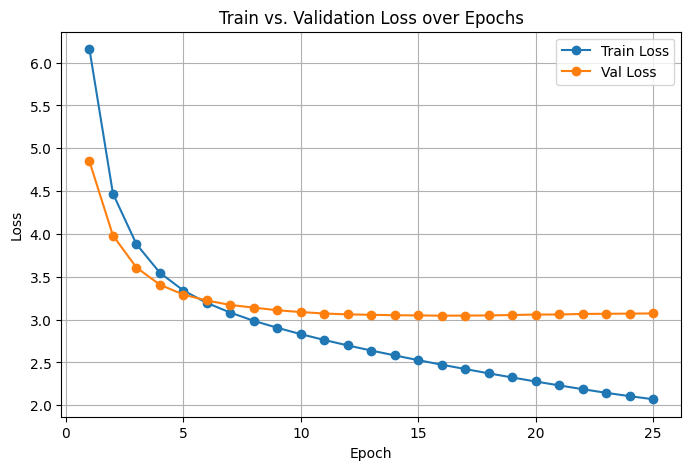

In [89]:
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses,   marker='o', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [91]:
!pip install tabulate

In [5]:
import pandas as pd
from tabulate import tabulate

In [6]:
with open("results.json", "r", encoding="utf-8") as f:
    results = json.load(f)

In [7]:
df = pd.DataFrame(results)

In [8]:
rouge_df = df["rouge"].apply(pd.Series)
rouge_df.columns = ["rouge1", "rouge2", "rougeL"]

In [9]:
df = pd.concat([df.drop(columns=["rouge"]), rouge_df], axis=1)

In [10]:
display_df = df[["epoch", "rouge1", "rouge2", "rougeL"]]

In [12]:
print(tabulate(display_df, headers="keys", tablefmt="psql", showindex=False))

+---------+----------+-----------+----------+
|   epoch |   rouge1 |    rouge2 |   rougeL |
|---------+----------+-----------+----------|
|       5 | 0.271596 | 0.0710721 | 0.211202 |
|      10 | 0.290982 | 0.0851596 | 0.226525 |
|      15 | 0.300244 | 0.0915641 | 0.234104 |
|      16 | 0.299387 | 0.0918897 | 0.232703 |
|      17 | 0.300989 | 0.0920619 | 0.234134 |
|      20 | 0.30415  | 0.0948534 | 0.236394 |
|      25 | 0.305513 | 0.0959938 | 0.237651 |
+---------+----------+-----------+----------+
